In [ ]:
!uv sync

Resolved 46 packages in 3ms
Audited 41 packages in 1ms


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# 1. Merge all data of a category into one

In [3]:
def load_and_merge(folder_path, category_name):
    # Get all the csv file
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(f"Found {len(all_files)} files for {category_name}")

    # make iterable of dataframes
    df_list = []
    for file_name in all_files:
        df_list.append(pd.read_csv(file_name))

    # merge all dataframes
    merged_df = pd.concat(df_list, axis=0, ignore_index=True)
    print(f"Total row in {category_name}: {len(merged_df)}")

    return merged_df

### 1.1 Paths of all the dataset

In [4]:
basepath = "datasets"

biometric_path = os.path.join(basepath, "api_data_aadhar_biometric")
demographic_path = os.path.join(basepath, "api_data_aadhar_demographic")
enrolment_path = os.path.join(basepath, "api_data_aadhar_enrolment")

### 1.2 Dataframse of datasets

In [5]:
df_biometric = load_and_merge(biometric_path, "Biometric")
df_demographic = load_and_merge(demographic_path, "Demographic")
df_enrolment = load_and_merge(enrolment_path, "Enrolment")

Found 4 files for Biometric
Total row in Biometric: 1861108
Found 5 files for Demographic
Total row in Demographic: 2071700
Found 3 files for Enrolment
Total row in Enrolment: 1006029


### 1.3 Cleaning Data

In [6]:
state_mapping = {
    "ORISSA": "ODISHA",
    "UTTARANCHAL": "UTTARAKHAND",
    "PONDICHERRY": "PUDUCHERRY",
    "WEST  BENGAL": "WEST BENGAL",
    "WESTBENGAL": "WEST BENGAL",
    "WEST BANGAL": "WEST BENGAL",
    "WEST BENGLI": "WEST BENGAL",
    "CHHATISGARH": "CHHATTISGARH",
    "JAMMU & KASHMIR": "JAMMU AND KASHMIR",
    "DAMAN & DIU": "DAMAN AND DIU",
    "DADRA & NAGAR HAVELI": "DADRA AND NAGAR HAVELI",
    "THE DADRA AND NAGAR HAVELI AND DAMAN AND DIU":
        "DADRA AND NAGAR HAVELI AND DAMAN AND DIU"
}

In [7]:
valid_states = {
    "ANDHRA PRADESH", "ARUNACHAL PRADESH", "ASSAM", "BIHAR",
    "CHHATTISGARH", "GOA", "GUJARAT", "HARYANA",
    "HIMACHAL PRADESH", "JHARKHAND", "KARNATAKA", "KERALA",
    "MADHYA PRADESH", "MAHARASHTRA", "MANIPUR", "MEGHALAYA",
    "MIZORAM", "NAGALAND", "ODISHA", "PUNJAB", "RAJASTHAN",
    "SIKKIM", "TAMIL NADU", "TELANGANA", "TRIPURA",
    "UTTAR PRADESH", "UTTARAKHAND", "WEST BENGAL",
    "DELHI", "CHANDIGARH", "PUDUCHERRY", "LADAKH",
    "JAMMU AND KASHMIR", "LAKSHADWEEP",
    "ANDAMAN AND NICOBAR ISLANDS",
    "DADRA AND NAGAR HAVELI AND DAMAN AND DIU"
}


In [8]:
dfs = [df_biometric, df_demographic, df_enrolment]

for i, df in enumerate(dfs):

    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")

    if "district" in df.columns:
        df["district"] = df["district"].astype(str).str.strip().str.upper()

    if "state" in df.columns:
        df["state"] = (
            df["state"]
            .astype(str)
            .str.strip()
            .str.upper()
            .replace(state_mapping)
        )

        # remove numeric-only values
        df = df[~df["state"].str.fullmatch(r"\d+", na=False)]

        # keep only valid states
        df = df[df["state"].isin(valid_states)]

    dfs[i] = df  

df_biometric, df_demographic, df_enrolment = dfs


# 2. Analysis

## 2.1 THE "DIGITAL vs PHYSICAL" UPDATE TREND

In [9]:
total_demo = df_demographic[['demo_age_5_17', 'demo_age_17_']].sum().sum()
total_bio = df_biometric[['bio_age_5_17', 'bio_age_17_']].sum().sum()
print(f"Raw Sums -> Demo: {total_demo}, Bio: {total_bio}")


Raw Sums -> Demo: 49285651, Bio: 69723974


/tmp/ipykernel_15098/2821448308.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Demographic Updates', 'Biometric Updates'], y=[total_demo, total_bio], palette='viridis')


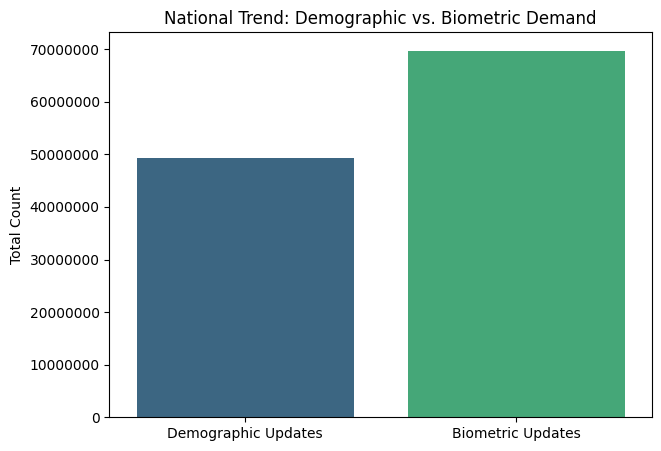

In [18]:
plt.figure(figsize=(7, 5))
sns.barplot(x=['Demographic Updates', 'Biometric Updates'], y=[total_demo, total_bio], palette='viridis')
plt.ticklabel_format(style='plain', axis='y')
plt.title('National Trend: Demographic vs. Biometric Demand')
plt.ylabel('Total Count')
plt.savefig('demo_vs_bio.png')

## 2.2 THE CHILD COMPLIANCE GAP (MBU ANALYSIS)

In [ ]:
# We compare age 0-5 enrolments vs age 5-17 Biometric Updates
state_child_enrol = df_enrolment.groupby('state')['age_0_5'].sum()
state_child_bio = df_biometric.groupby('state')['bio_age_5_17'].sum()

state
ANDAMAN AND NICOBAR ISLANDS                    370
ANDHRA PRADESH                              112445
ARUNACHAL PRADESH                             1957
ASSAM                                       141235
BIHAR                                       262875
CHANDIGARH                                    2476
CHHATTISGARH                                 82453
DADRA AND NAGAR HAVELI AND DAMAN AND DIU       679
DELHI                                        69183
GOA                                           1916
GUJARAT                                     193031
HARYANA                                      88042
HIMACHAL PRADESH                             16639
JAMMU AND KASHMIR                            40539
JHARKHAND                                    98551
KARNATAKA                                   179262
KERALA                                       53737
LADAKH                                         466
LAKSHADWEEP                                    192
MADHYA PRADESH           

In [12]:
# Identify where child biometric updates are lagging behind enrolments
child_gap_ratio = (state_child_bio / state_child_enrol).sort_values(ascending=False)

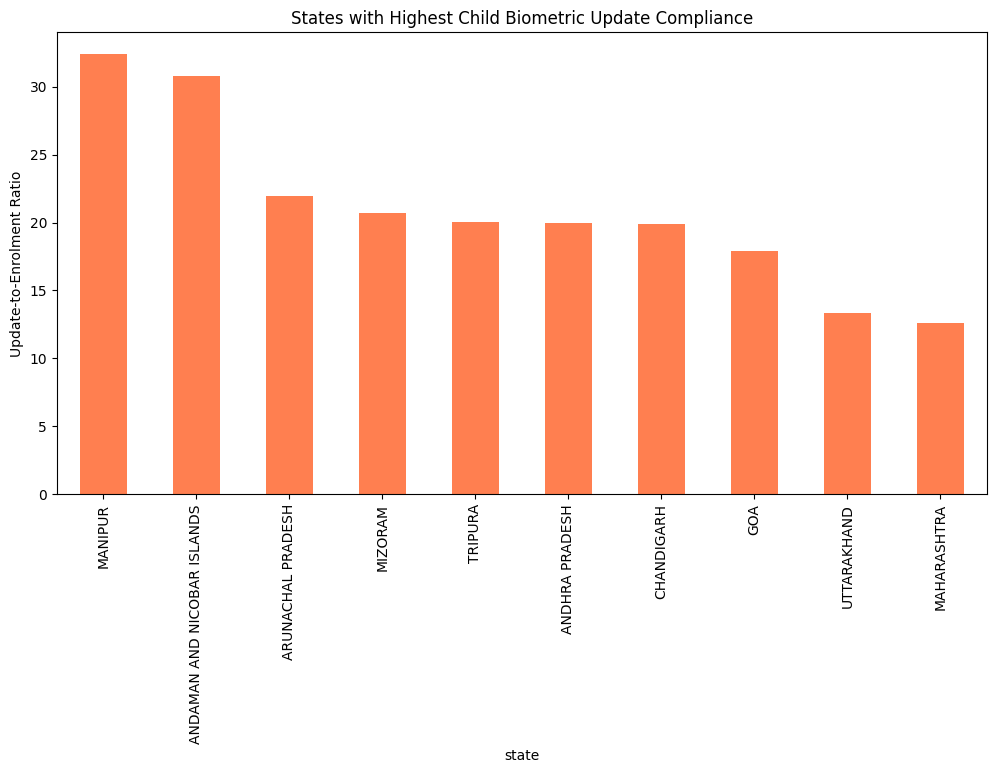

In [ ]:
plt.figure(figsize=(12, 6))
child_gap_ratio.head(10).plot(kind='bar', color='coral')
plt.title('States with Highest Child Biometric Update Compliance')
plt.ylabel('Update-to-Enrolment Ratio')
plt.savefig('child_compliance.png')

## 2.3 ADULT DIGITAL ADOPTION TREND (Time-Series)

In [14]:
# Tracking demo_age_17_ (Adults updating mobile/address for digital services)
df_demographic.set_index('date', inplace=True)
adult_digital_trend = df_demographic.resample('M')['demo_age_17_'].sum()

/tmp/ipykernel_15098/498457827.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  adult_digital_trend = df_demographic.resample('M')['demo_age_17_'].sum()


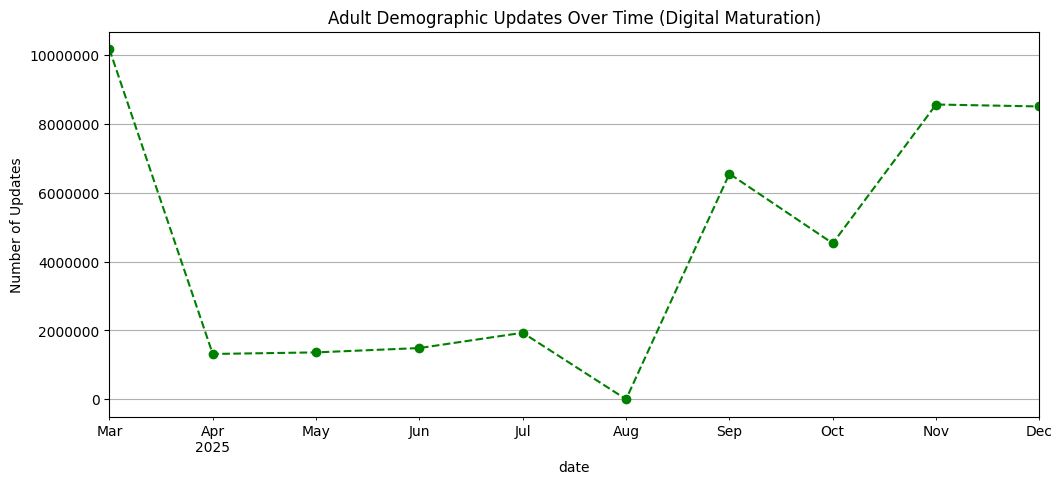

In [20]:
plt.figure(figsize=(12, 5))
adult_digital_trend.plot(color='green', marker='o', linestyle='--')
plt.ticklabel_format(style='plain', axis='y')
plt.title('Adult Demographic Updates Over Time (Digital Maturation)')
plt.ylabel('Number of Updates')
plt.grid(True)
plt.savefig('adult_trend.png')